In [1]:
import cv2

from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2 import model_zoo
from detectron2.checkpoint import DetectionCheckpointer

import torch

from types import MethodType

from modified_classes import ModifiedFastRCNNOutputLayers, ModifiedImageList

import os
os.listdir('assets')

['crocodile_frcnn.pt_train_config.yaml',
 'crocodile_frcnn.pt.classes',
 'crocodile_FRCNN_data_snapshot.txt',
 'crocodile_frcnn.pt']

In [2]:
import IPython

# if input image is in range 0..1, please first multiply img by 255
# assume image is ndarray of shape [height, width, channels] where channels can be 1, 3 or 4
def imshow(img):
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

## Load base detectron2 model, run on test img

In [5]:
model_path = 'assets/crocodile_frcnn.pt'
device = torch.device("cpu")

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.3
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.WEIGHTS = model_path

model = build_model(cfg).to(device).eval()
DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)

{}

[{'instances': Instances(num_instances=2, image_height=800, image_width=1200, fields=[pred_boxes: Boxes(tensor([[  75.8069,   75.4301, 1117.9500,  569.0178],
        [ 134.1388,   98.4592,  566.9828,  396.5439]], grad_fn=<IndexBackward>)), scores: tensor([0.9981, 0.9359], grad_fn=<IndexBackward>), class_scores: tensor([[0.9981],
        [0.9359]]), pred_classes: tensor([0, 0])])}]


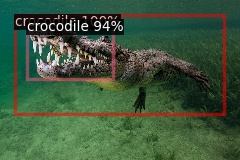

In [6]:
# img1 = cv2.imread('dataset/closeups/_DSC9814.jpg')
# img2 = cv2.imread('dataset/land/114.jpg')
# img3 = cv2.imread('dataset/night/20201201_000505.jpg')
img4 = cv2.imread('dataset/swamp/01598846.jpg')

for img in [img4]:
    outputs = model(torch.from_numpy(img).permute(2,0,1).unsqueeze(0).to(device))
    print(outputs)

    from detectron2.utils.visualizer import Visualizer
    from detectron2.data import MetadataCatalog

    v = Visualizer(img[:, :, ::-1], {"thing_classes": ["crocodile"]},scale=0.2)
    out = v.draw_instance_predictions(outputs[0]["instances"].to("cpu"))
    imshow(out.get_image()[:, :, ::-1])

## Select images

In [7]:
import json

with open('assets/crocodile_FRCNN_data_snapshot.txt') as f:
    data = json.load(f)

In [8]:
train_imgs = [img['original_name'] for img in data['resource']['images'] if img['purpose'] == 'train']
val_imgs = [img['original_name'] for img in data['resource']['images'] if img['purpose'] == 'validate']

In [9]:
os.listdir('dataset')

['swamp', 'land', 'closeups', 'night']

In [10]:
import random
random.seed(42)

selected_imgs = {}

for key in sorted(os.listdir('dataset')):
    selected_imgs[key] = {'train': '', 'val': '', 'test': ''}
    
    key_imgs = sorted([f for f in os.listdir(f'dataset/{key}') if f[-4:] == '.jpg'])
    random.shuffle(key_imgs)
    
    for img in key_imgs:
        if img[:-4] in train_imgs and (not selected_imgs[key]['train']):
            selected_imgs[key]['train'] = img
        elif img[:-4] in val_imgs and (not selected_imgs[key]['val']):
            selected_imgs[key]['val'] = img
        elif (not selected_imgs[key]['test']):
            selected_imgs[key]['test'] = img
    
selected_imgs

{'closeups': {'train': 'Spencer_Yau_Crocodile (79).jpg',
  'val': 'Spencer_Yau_Crocodile (68).jpg',
  'test': 'Spencer_Yau_Crocodile (109).jpg'},
 'land': {'train': 'Spencer_Yau_Crocodile (253).jpg',
  'val': 'croc.jpg',
  'test': 'Yee_Tien_Crocodile (179).jpg'},
 'night': {'train': '20201201_000715.jpg',
  'val': '20201201_000533.jpg',
  'test': '20201201_000505.jpg'},
 'swamp': {'train': '20201112_130928.jpg',
  'val': '_DSC8840.jpg',
  'test': '20210214_184156.jpg'}}

closeups train (853, 1280, 3)


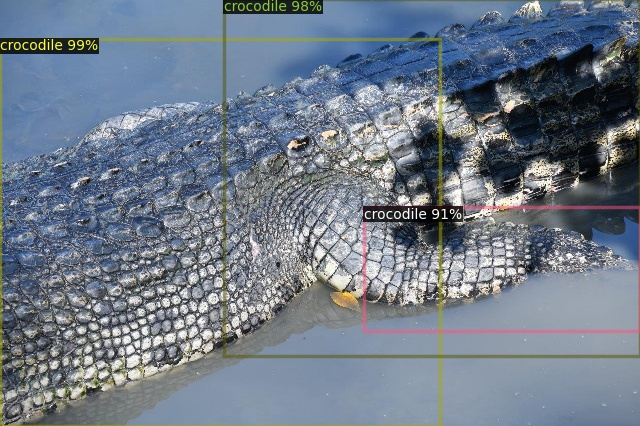

closeups val (853, 1280, 3)


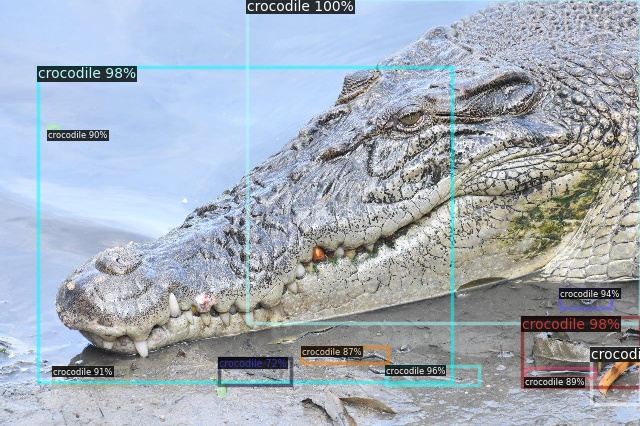

closeups test (853, 1280, 3)


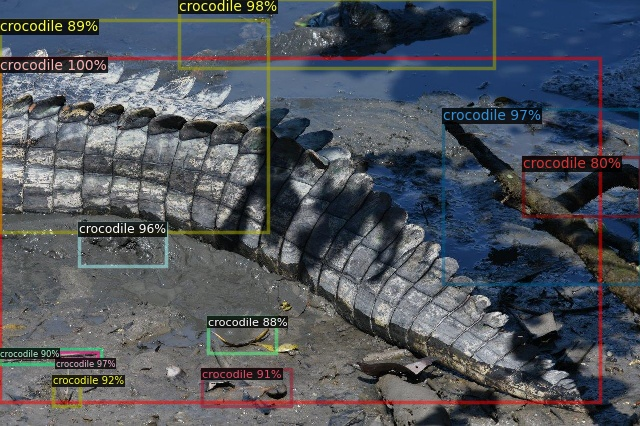

land train (853, 1280, 3)


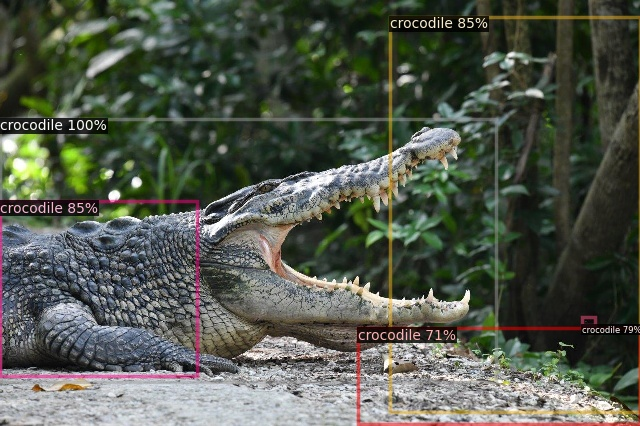

land val (921, 1382, 3)


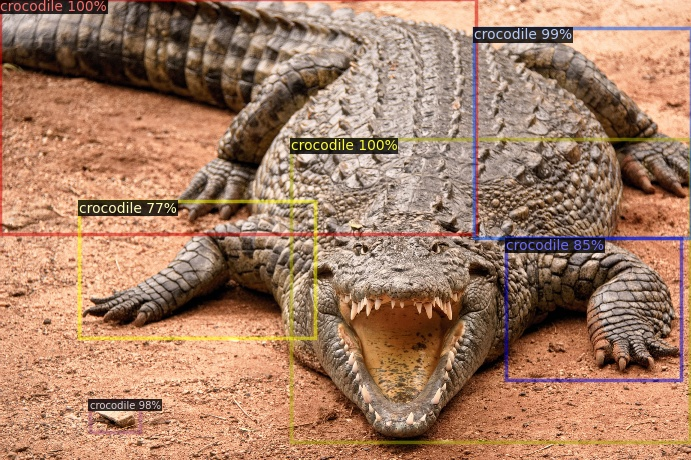

land test (853, 1280, 3)


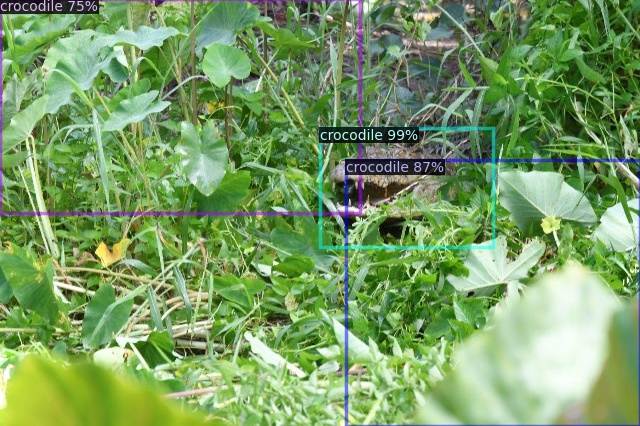

night train (1008, 756, 3)


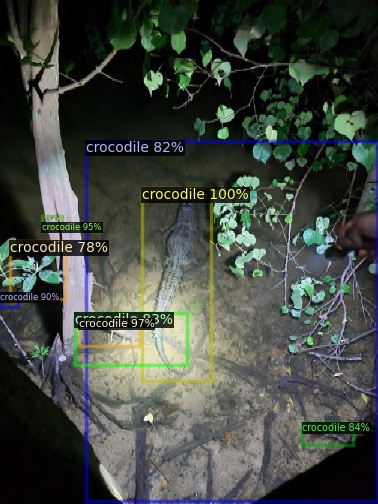

night val (1008, 756, 3)


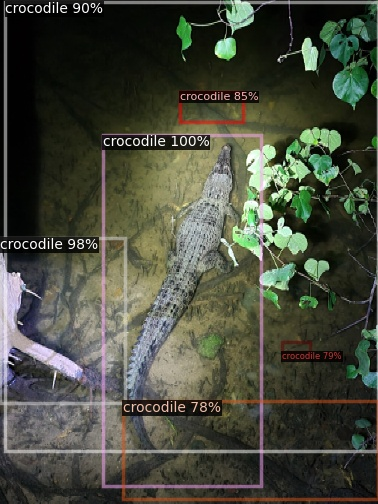

night test (1008, 756, 3)


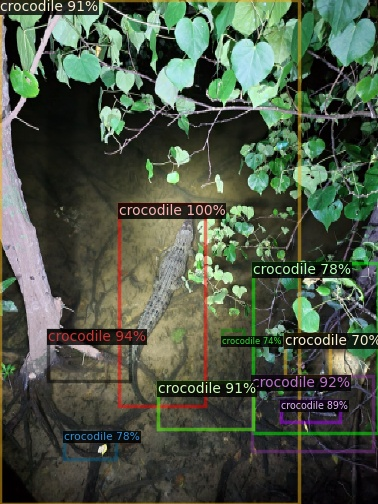

swamp train (1008, 756, 3)


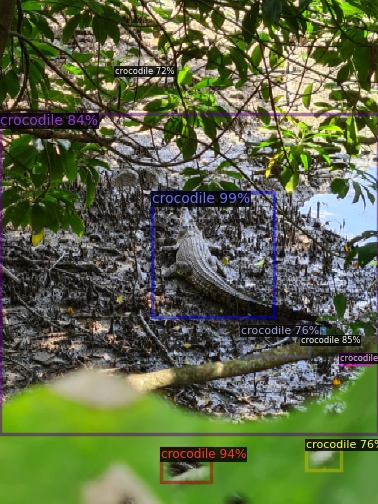

swamp val (853, 1280, 3)


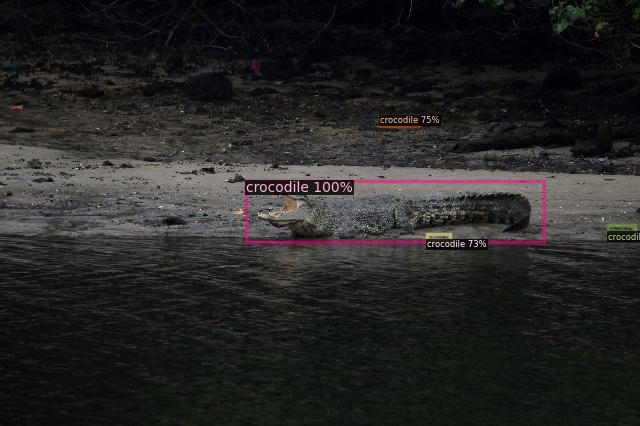

swamp test (1008, 756, 3)


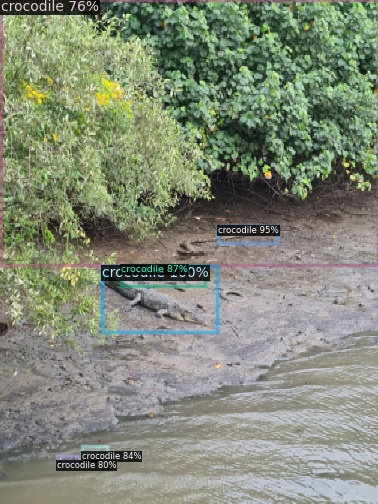

In [11]:
for key in selected_imgs.keys():
    for split in selected_imgs[key].keys():
        img = cv2.imread(f'dataset/{key}/{selected_imgs[key][split]}')
        
        while img.shape[0] > 1000:
            img = cv2.resize(img, (img.shape[0]//2, img.shape[1]//2), interpolation = cv2.INTER_AREA)
        while img.shape[0] < 500:
            img = cv2.resize(img, (img.shape[0]*2, img.shape[1]*2), interpolation = cv2.INTER_AREA)

        print(key, split, img.shape)
        outputs = model(torch.from_numpy(img).permute(2,0,1).unsqueeze(0).to(device))
        
        v = Visualizer(img[:, :, ::-1], {"thing_classes": ["crocodile"]},scale=0.5)
        out = v.draw_instance_predictions(outputs[0]["instances"].to("cpu"))
        imshow(out.get_image()[:, :, ::-1])

## Night test image is q noisy, let's choose that

night test (1008, 756, 3)


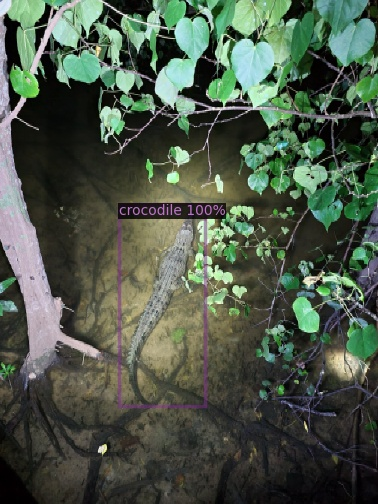

In [17]:
key = 'night'
split = 'test'
img = cv2.imread(f'dataset/{key}/{selected_imgs[key][split]}')

while img.shape[0] > 1000:
    img = cv2.resize(img, (img.shape[0]//2, img.shape[1]//2), interpolation = cv2.INTER_AREA)
while img.shape[0] < 500:
    img = cv2.resize(img, (img.shape[0]*2, img.shape[1]*2), interpolation = cv2.INTER_AREA)

print(key, split, img.shape)
outputs = model(torch.from_numpy(img).permute(2,0,1).unsqueeze(0).to(device))

v = Visualizer(img[:, :, ::-1], {"thing_classes": ["crocodile"]},scale=0.5)

# just pick the first of the instances since they are sorted in descending confidence level
out = v.draw_instance_predictions(outputs[0]["instances"][0].to("cpu"))
imshow(out.get_image()[:, :, ::-1])

## Add modified classes to change output of model

In [18]:
def new_preprocess_image(self, batched_inputs: torch.Tensor):
      """
      Normalize, pad and batch the input images.
      """
      # print(type(batched_inputs))
      images = [x.to(self.device) for x in batched_inputs]
      images = [(x - self.pixel_mean) / self.pixel_std for x in images]
      images = ModifiedImageList.from_tensors(images, self.backbone.size_divisibility) # Extend ImageList to new object
      return images

def _new_postprocess(instances, batched_inputs: torch.Tensor, image_sizes):
        """
        Rescale the output instances to the target size.
        """
        # note: private function; subject to changes
        processed_results = []
        # print(type(batched_inputs))
        for results_per_image, input_per_image, image_size in zip(
            instances, batched_inputs, image_sizes
        ):
            height = image_size[0]
            width = image_size[1]
            from detectron2.modeling.postprocessing import detector_postprocess
            r = detector_postprocess(results_per_image, height, width)
            processed_results.append({"instances": r})
        return processed_results

model.roi_heads.box_predictor = ModifiedFastRCNNOutputLayers(model.roi_heads.box_predictor)
model.preprocess_image = MethodType(new_preprocess_image, model)
model.__class__._postprocess = _new_postprocess
model.roi_heads.forward_with_given_boxes = MethodType(lambda self, x, y: y, model)

modified = model

DetectionCheckpointer(modified).load(cfg.MODEL.WEIGHTS)
modified.to(device)

modified.roi_heads.box_predictor.class_scores_only = True

In [28]:
key = 'night'
split = 'test'
img = cv2.imread(f'dataset/{key}/{selected_imgs[key][split]}')

while img.shape[0] > 1000:
    img = cv2.resize(img, (img.shape[0]//2, img.shape[1]//2), interpolation = cv2.INTER_AREA)
while img.shape[0] < 500:
    img = cv2.resize(img, (img.shape[0]*2, img.shape[1]*2), interpolation = cv2.INTER_AREA)

input_   = torch.from_numpy(img).permute(2,0,1).unsqueeze(0).to(device).type(torch.cuda.FloatTensor)
baseline = torch.zeros(input_.shape).to(device).type(torch.cuda.FloatTensor)
baseline_dist = torch.randn(5, 3, 480, 640).to(device) * 0.001

outputs = modified.inference(input_, do_postprocess=False)
# outputs : List[Tensor(Instances * class)]
torch.max(outputs[0])

PREDICTIONS: [torch.Size([1000, 2]), torch.Size([1000, 4])]


tensor(0.9975, grad_fn=<MaxBackward1>)

In [27]:
class WrapperModel(torch.nn.Module):
      def __init__(self):
            super().__init__()
            self.model = modified

      def forward(self, input):
            outputs = self.model.inference(input, do_postprocess=False)
            acc = []
            for i in range(len(outputs)):
                  if outputs[i].shape[0] != 0:
                        acc.append(outputs[i][0].unsqueeze(0))
                  else:
                        acc.append(torch.cat([outputs[i],
                                          torch.zeros((1, outputs[i].shape[1])).to(device)]))
            return torch.cat(acc)

In [29]:
wrapper = WrapperModel()

In [31]:
wrapper(input_).shape

PREDICTIONS: [torch.Size([1000, 2]), torch.Size([1000, 4])]


torch.Size([1, 1])